In [113]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.ensemble import VotingRegressor
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.forecasting.sarimax import SARIMAX

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sklearn.neighbors import LocalOutlierFactor
import itertools

import warnings
warnings.filterwarnings('ignore')

In [114]:
datafile = 'test_task_1.xlsx'
df = pd.read_excel(datafile, sheet_name = 'days', parse_dates=['report_dt'], index_col='report_dt')
df = df.sort_values(by=['report_dt', 'territ_subdiv_1', 'territ_subdiv_2'])
df.head()

,territ_subdiv_1,territ_subdiv_2,val
report_dt,,,
2019-05-31,1,1,1.0
2019-05-31,1,2,1.0
2019-05-31,1,3,1.0
2019-05-31,1,4,1.0
2019-05-31,1,5,1.0


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40973 entries, 2019-05-31 to 2020-11-21
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   territ_subdiv_1  40973 non-null  int64  
 1   territ_subdiv_2  40973 non-null  int64  
 2   val              40973 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.3 MB


In [116]:
df.describe()

,territ_subdiv_1,territ_subdiv_2,val
count,40973.000000,40973.000000,40973.000000
mean,6.449540,5.328851,1.258391
std,3.037036,3.143999,0.417794
min,1.000000,1.000000,0.134688
25%,5.000000,3.000000,1.016003
50%,7.000000,5.000000,1.133837
75%,9.000000,8.000000,1.320846
max,11.000000,15.000000,4.160394


In [117]:
len(df.index.unique())

464

In [118]:
df_total = df.groupby(df.index).agg({'val': 'sum'}).rename(columns={'val': 'val'})

In [119]:
df_total.head()

,val
report_dt,
2019-05-31,89.000000
2019-06-01,61.545222
2019-06-03,150.841168
2019-06-04,78.471047
2019-06-05,78.572627


Посмотрим на график по выручке за весь период

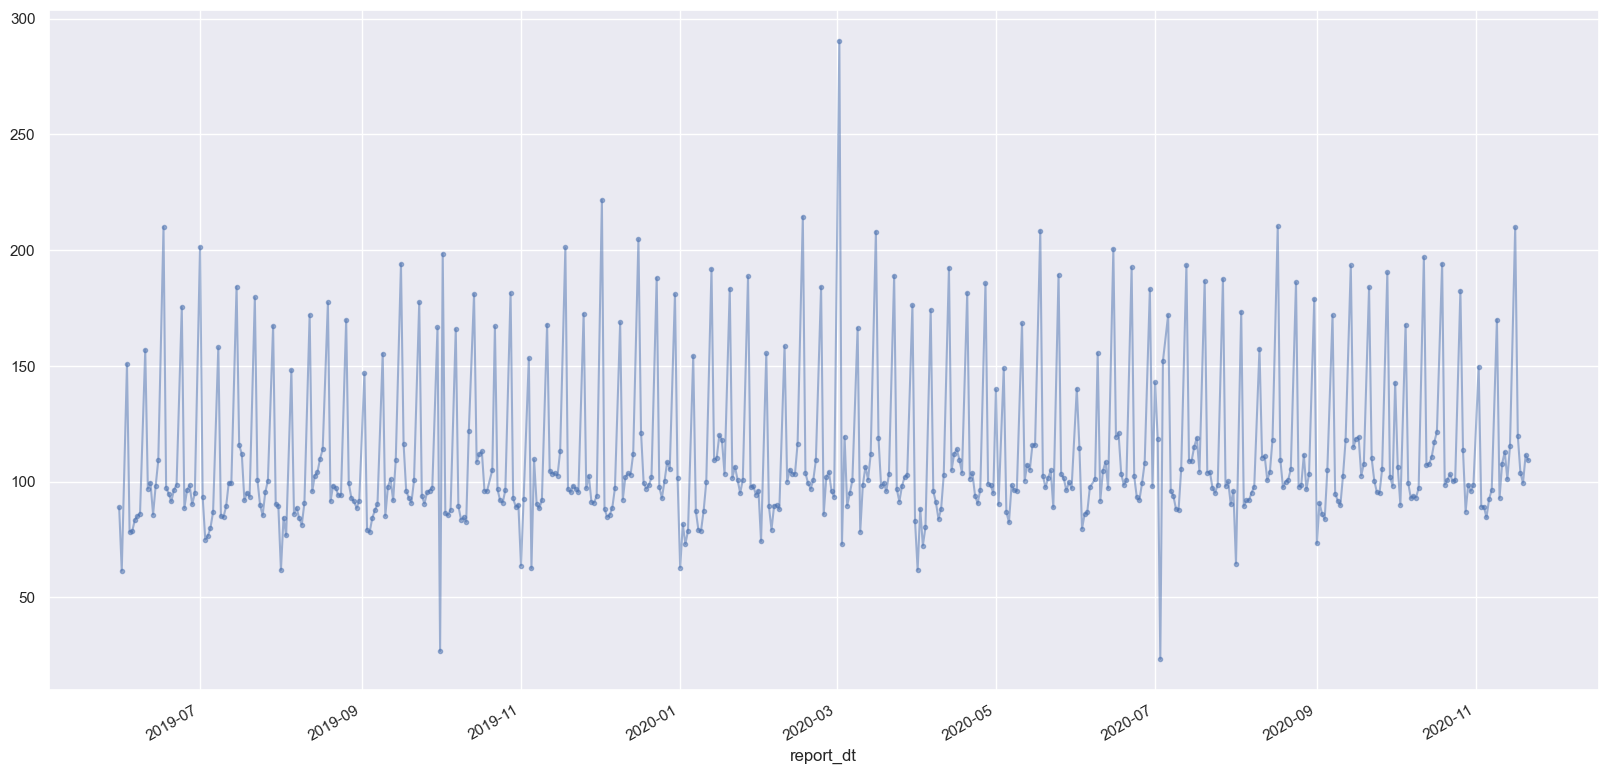

In [120]:
df_total['val'].plot(marker='.', alpha=0.5, linestyle='-', figsize=(20, 10), subplots=True)
plt.show()

На нрафике видна довольно сильная сезонная компонента и есть несколько аномально высоких и низких значений. Также мы можем наблюдать восходящий тренд

In [121]:
def plot_an(data,  anomalies =None, column = 'val', figsize = (18,6), ax=None,
             fill_an = False, score_column=None, anomaly_column = None):

    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)

    y = data[column].values.reshape(-1, 1)
    ax.plot(data.index, y, c='k', label = column, zorder=10)

    if  anomalies is not None:
        if anomaly_column is None:
            anomaly_column = column

        anomalies = pd.DataFrame(anomalies, columns=[anomaly_column, score_column])

        idxs = pd.DataFrame(anomalies).loc[anomalies[anomaly_column] ==True].index
        an_data = pd.DataFrame(data.loc[idxs,column] )

        y_an = an_data.values.reshape(-1, 1)

        if fill_an:
            idx = data.index
            points = [{'fp':idx[i-1], 'lp':idx[i+1]} for i in range(1,len(idx)-1) if anomalies.iloc[i].Consumption==True]
            points = pd.DataFrame(points)
            [ax.axvspan(points.fp[i], points.lp[i], alpha=.5, color='green', zorder=2) for i in range(len(points))];

        an_size = 20
        if score_column is not None:
            score_ = anomalies.loc[anomalies[score_column] !=0,score_column].values.squeeze()
            an_size = 40*np.abs(score_)

        ax.scatter(an_data.index, y_an, marker='o', s=an_size, color = 'red', label = 'Anomaly', zorder=100 )
    l = plt.legend()
    l.set_zorder(2000)

    return ax

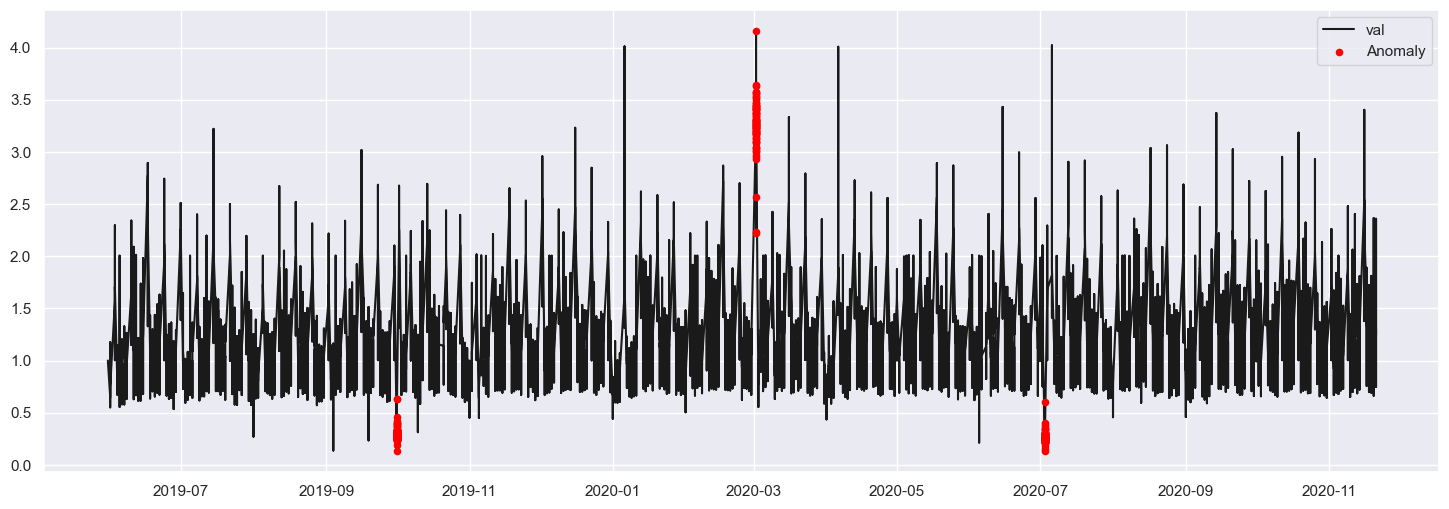

In [122]:
from sklearn.ensemble import IsolationForest

y = df_total.val.values.reshape(-1, 1)


outliers_fraction = 0.005

model =  IsolationForest(contamination=outliers_fraction)
df_total['anomaly'] = model.fit_predict(y)
an = pd.DataFrame(df_total['anomaly']==-1).rename(columns={'anomaly':'val'})

plot_an(df, an);

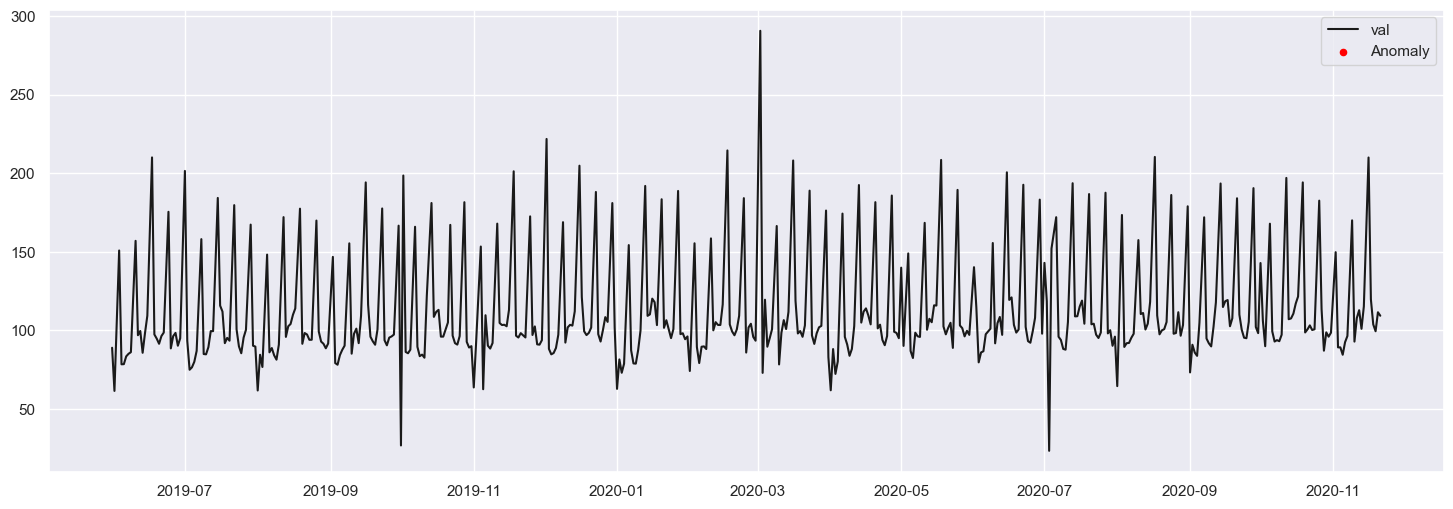

In [123]:
model = LocalOutlierFactor(novelty=True)
model.fit(y)
df_total['anomaly'] = model.predict(y)
an = pd.DataFrame(df_total['anomaly']==-1).rename(columns={'anomaly':'Consumption'})

plot_an(df_total, an);

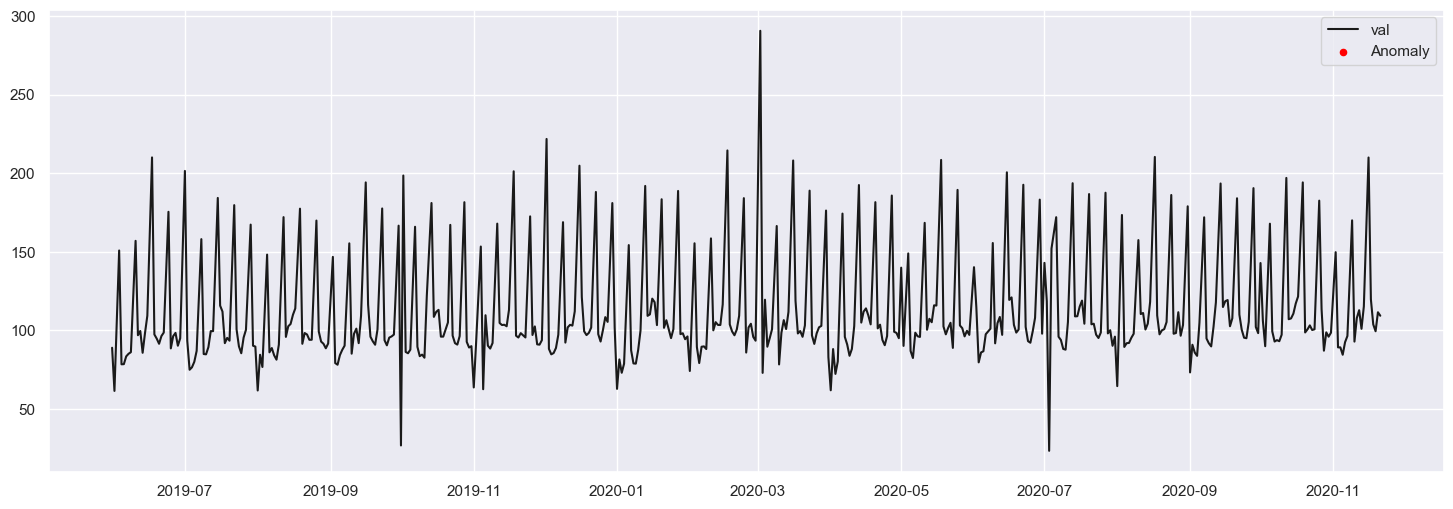

In [124]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10)
model.fit(y)
df_total['anomaly'] = model.fit_predict(y)
an = pd.DataFrame(df_total['anomaly']==-1).rename(columns={'anomaly':'Consumption'})
plot_an(df_total, an);

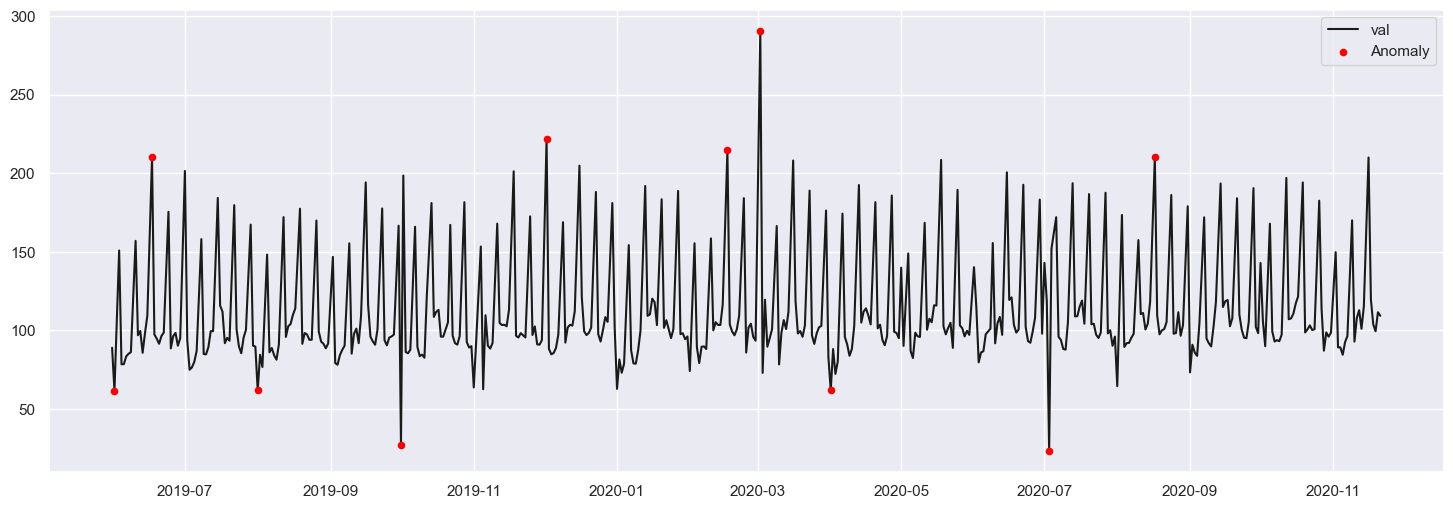

In [23]:
from adtk.detector import QuantileAD

quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df_total)

plot_an(df_total, anomalies);

Во временном ряду как показали тесты достаточно не много аномалий. 2 теста из 4 показали их отсутствие, а 4й тест показал всего 10 аномальных значений на весь ряд.

In [125]:
anomalies[anomalies['val']]

,val,year,month,anomaly
report_dt,,,,
2019-06-01,True,False,False,False
2019-06-17,True,False,False,False
2019-08-01,True,False,False,False
2019-10-01,True,False,False,False
2019-12-02,True,False,False,False
2020-02-17,True,False,False,False
2020-03-02,True,False,False,False
2020-04-01,True,False,False,False
2020-07-03,True,False,False,False


In [134]:
df_total = df_total.drop('anomaly', axis=1)

In [140]:
df_total[445:]

,val
report_dt,
2020-10-31,98.566648
2020-11-02,149.764781
2020-11-03,89.252398
2020-11-04,89.229498
2020-11-05,84.545795
2020-11-06,92.529745
2020-11-07,96.462241
2020-11-09,170.004005
2020-11-10,92.912033


### Для ноября 2020 года в начале года был сформирован прогноз 3188.91. Используя дневные данные на листе days, уточните этот прогноз.

Создадим датафрейм df_test оставшимися числами ноября, обратим внимание, что за воскресение данных нет, не будем создавать даты, которые выпадют на воскресенье

In [141]:
df_total['week_day'] = df_total.index.dayofweek + 1

all_dates = pd.date_range(start=df_total.index.min(), end=df_total.index.max(), freq='D')
all_dates_df = pd.DataFrame(index=all_dates)
all_dates_df['week_day'] = all_dates_df.index.dayofweek + 1

merged_df = all_dates_df.merge(df_total, how='left', left_index=True, right_index=True)

missing_days = merged_df[merged_df['val'].isna()]

missing_days_count = missing_days['week_day_x'].value_counts().to_dict()

missing_days_count_full = {day: 0 for day in range(1, 8)}
missing_days_count_full.update(missing_days_count)

print("Количество пропущенных дней недели:")
print(missing_days_count_full)

print("\nDataFrame с добавленной колонкой week_day:")
print(df_total.head())

Количество пропущенных дней недели:
{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 77}

DataFrame с добавленной колонкой week_day:
                   val  week_day
report_dt                       
2019-05-31   89.000000         5
2019-06-01   61.545222         6
2019-06-03  150.841168         1
2019-06-04   78.471047         2
2019-06-05   78.572627         3


In [142]:
df_total[df_total['week_day'] == 7]

,val,week_day
report_dt,,


In [143]:
df_total = df_total.drop('week_day', axis=1)

Всего у нас есть данные за 464 дня. Если смотреть по датам, то 77 дней пропущено и все они приходятся на воскресенье. Вероятно, воскресение выходной день и комиссионых дозод не считается на этот день.  
Однако для корректной работы всех моделей нам нужно восстановить датасет. Мы просто заполим VAL в пропущенных днях нулями, так выручка в такой лень не начислается.

In [175]:
df_test = pd.DataFrame({
    'report_dt': ['2020-11-22','2020-11-23','2020-11-24','2020-11-25','2020-11-26','2020-11-27','2020-11-28','2020-11-29','2020-11-30'],
    'val': np.nan,
})

In [176]:
df_test = df_test.set_index('report_dt')
df_test

,val
report_dt,
2020-11-22,NaN
2020-11-23,NaN
2020-11-24,NaN
2020-11-25,NaN
2020-11-26,NaN
2020-11-27,NaN
2020-11-28,NaN
2020-11-29,NaN
2020-11-30,NaN


Если просто посчитать в лоб средними значениями ноября то общая сумма комиссионного дохода составит: 2855.208302777778

In [146]:
sum_11 = df_total[(df_total.index >= '2020-11-01')]['val'].sum()

In [147]:
mean_11 = df_total[(df_total.index >= '2020-11-01')]['val'].mean()

In [148]:
forecast_11 = sum_11 + mean_11 * 7
forecast_11

2855.208302777778

Конечно такой прогноз очень грубый, и по нему судить нельзя, но все же он существенно ниже, чем прогнозировали в начале года

Создадим несколько моделей и протестируем их по метрике smape

In [ ]:
full_dates = pd.date_range(start=df_total.index.min(), end=df_total.index.max(), freq='D')
df_total = df_total.reindex(full_dates, fill_value=0).rename_axis('report_dt').reset_index()

In [181]:
if 'report_dt' in df_total.columns:
    df_total = df_total.set_index('report_dt')

full_dates = pd.date_range(start=df_total.index.min(), end='2020-11-30', freq='D')

df_total = df_total.reindex(full_dates, fill_value=None).rename_axis('report_dt').reset_index()

In [183]:
df_total[540:]

,report_dt,val
540,2020-11-21,109.350872
541,2020-11-22,NaN
542,2020-11-23,NaN
543,2020-11-24,NaN
544,2020-11-25,NaN
545,2020-11-26,NaN
546,2020-11-27,NaN
547,2020-11-28,NaN
548,2020-11-29,NaN
549,2020-11-30,NaN


In [184]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   report_dt  550 non-null    datetime64[ns]
 1   val        541 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.7 KB


In [190]:
df_total = df_total.set_index('report_dt')

In [191]:
df_train = df_total[~df_total['val'].isna()]
df_test = df_total[df_total['val'].isna()]

In [192]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541 entries, 2019-05-31 to 2020-11-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   val     541 non-null    float64
dtypes: float64(1)
memory usage: 8.5 KB


In [193]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9 entries, 2020-11-22 to 2020-11-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   val     0 non-null      float64
dtypes: float64(1)
memory usage: 144.0 bytes


Check splitted data size: Train: 406, Test: 135


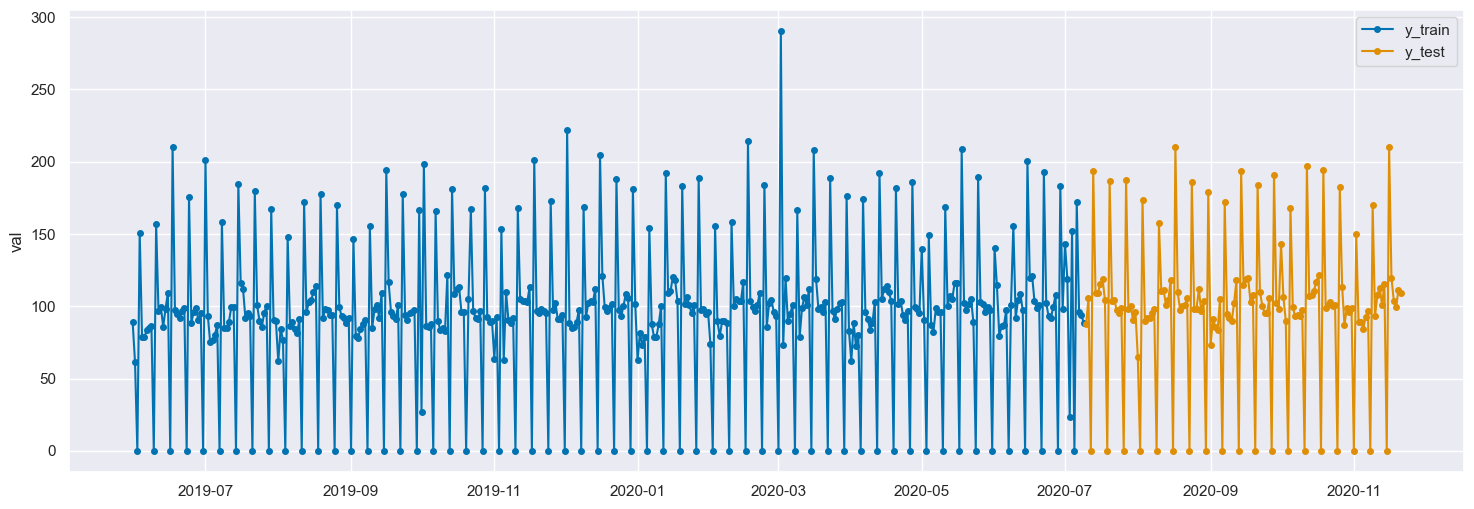

In [194]:
TEST_SIZE = int(0.25*df_train.shape[0])
y_train, y_test = temporal_train_test_split(df_train, test_size=TEST_SIZE)
print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')
fig, ax = plt.subplots(figsize=(18, 6))
plot_series(y_train, y_test, labels=["y_train", "y_test"], ax=ax)
plt.show()

In [195]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.croston import Croston
from sktime.forecasting.tbats import TBATS

In [233]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("season", NaiveForecaster(strategy="last", sp=7)),
        ("ets", ExponentialSmoothing(trend="add", sp=7)),
        ("hw", ExponentialSmoothing(trend="add", seasonal='add', sp=7)),
        ("TBATS", TBATS( sp=7,
                        use_box_cox=False,
                        use_trend=False,
                        use_damped_trend=False,
                        use_arma_errors=False,
                        n_jobs=1)),
        ("SARIMAX", SARIMAX( order=(0, 1, 4),
                            seasonal_order=(0, 1, 2, 6))),
        ('ARIMA', AutoARIMA( sp=7, 
                            suppress_warnings=True))
    ],
)
forecaster.set_params(**{"selected_forecaster": "ets"})

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('season', NaiveForecaster(sp=7)),
                                 ('ets',
                                  ExponentialSmoothing(sp=7, trend='add')),
                                 ('hw',
                                  ExponentialSmoothing(seasonal='add', sp=7,
                                                       trend='add')),
                                 ('TBATS',
                                  TBATS(n_jobs=1, sp=7, use_arma_errors=False,
                                        use_box_cox=False,
                                        use_damped_trend=False,
                                        use_trend=False)),
                                 ('SARIMAX',
                                  SARIMAX(order=(0, 1, 4),
                                          seasonal_order=(0, 1, 2, 6))),
                                 ('ARIMA',
                                  AutoARIMA(sp=7, suppress_warnings=True))],
                    selected_forecaster='ets')

In [234]:
cv = SlidingWindowSplitter(initial_window=203, window_length=101, step_length=52, fh=np.arange(len(y_test)) + 1)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive", "hw", "season", "TBATS", "SARIMAX", 'ARIMA']}

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=smape)

gscv.fit(y_train.values)

print(gscv.cv_results_.keys())

sorted_results = gscv.cv_results_.sort_values(by='mean_test_MeanAbsolutePercentageError', ascending=True)

print(sorted_results)

Index(['mean_test_MeanAbsolutePercentageError', 'mean_fit_time',
       'mean_pred_time', 'params', 'rank_test_MeanAbsolutePercentageError'],
      dtype='object')
   mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
3                               0.128164       0.015491        0.015268   
2                               0.369166       0.107583        0.003478   
4                               0.378187       0.755930        0.003264   
6                               0.390207       8.392533        0.008313   
5                               0.787750       0.752536        0.007640   
0                               0.881104       0.062244        0.003251   
1                               1.078529       0.014975        0.006239   

                               params  rank_test_MeanAbsolutePercentageError  
3   {'selected_forecaster': 'season'}                                    1.0  
2       {'selected_forecaster': 'hw'}                                    2.0 

Так у нас есть сильная сезонная составляющая в данных в виде отсутвия продаж в воскресение. Попробуем использовать ARIMA и SARIMAX вместе с Deseasonalizer

In [204]:
y_train['val'] = y_train['val'].apply(lambda x: 0.000001 if x == 0 else x)
y_test['val'] = y_test['val'].apply(lambda x: 0.000001 if x == 0 else x)

In [206]:
y_train.head()

,val
2019-05-31,89.000000
2019-06-01,61.545222
2019-06-02,0.000001
2019-06-03,150.841168
2019-06-04,78.471047


In [235]:
y_train = y_train.asfreq('D')

best_params = {
    'order': (1, 1, 4),
    'seasonal_order': (1, 1, 2, 12)
}

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=7)),
    ("forecast", SARIMAX(order=best_params['order'], seasonal_order=best_params['seasonal_order']))
])

forecaster.fit(y=y_train)

fh_test = np.arange(len(y_test)) + 1
y_pred = forecaster.predict(fh=fh_test)

In [236]:
print(f'SMAPE: {smape(y_test, y_pred):.4f}')

SMAPE: 0.0737


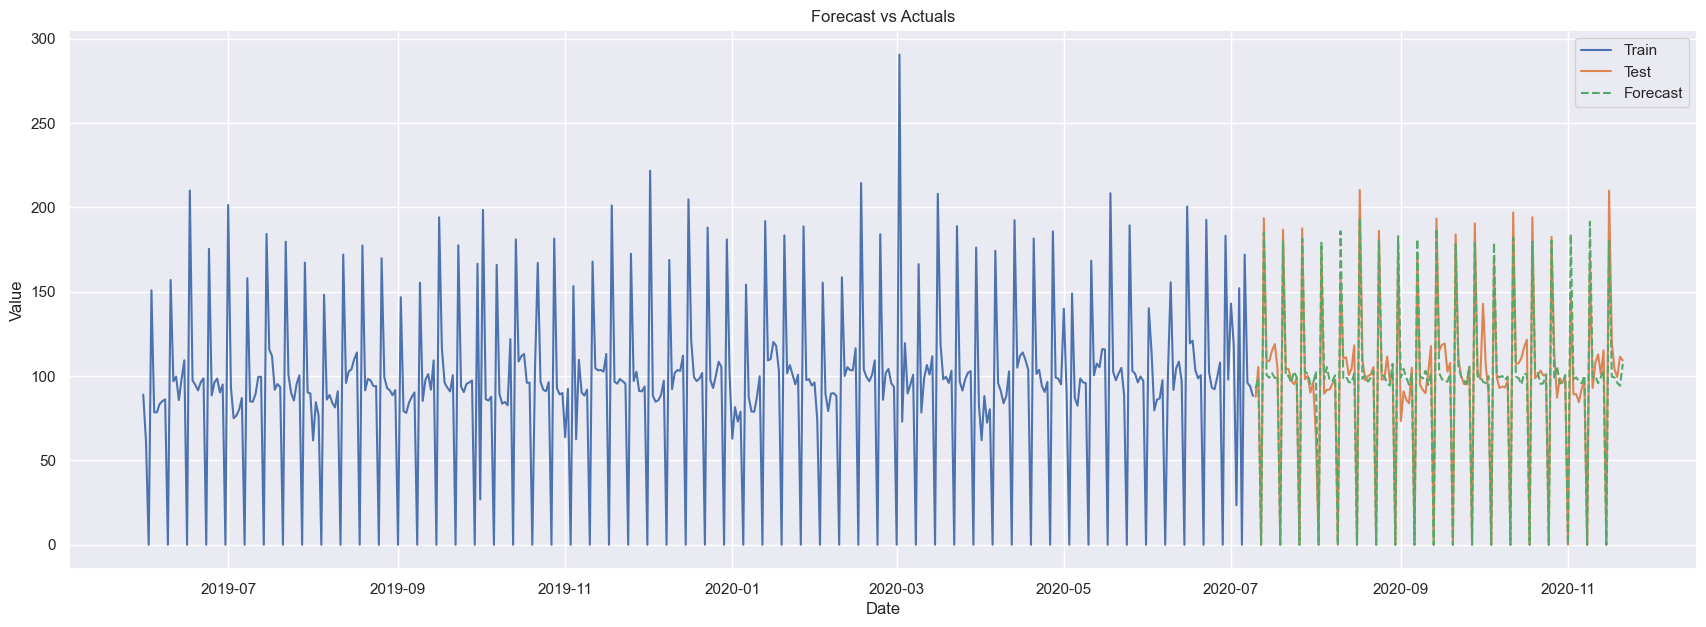

In [237]:
plt.figure(figsize=(21, 7))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_pred.index, y_pred, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actuals')
plt.legend()
plt.grid(True)
plt.show()

In [238]:
forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=7)),
    ("forecast", AutoARIMA(sp=7, suppress_warnings=True))
])

forecaster.fit(y=y_train)

fh_test = np.arange(len(y_test)) + 1
y_pred = forecaster.predict(fh=fh_test)

print(f'SMAPE: {smape(y_test, y_pred):.4f}')

SMAPE: 0.0719


Пока лучший результат получился у ARIMA вмесе с Deseasonalizer.  
Сравним с внешним фреймворком Prophet

In [256]:
df_train.head()

,val
report_dt,
2019-05-31,89.000000
2019-06-01,61.545222
2019-06-02,0.000000
2019-06-03,150.841168
2019-06-04,78.471047


In [267]:
prophet_data = y_train.copy()
prophet_data['ds'] = prophet_data.index
prophet_data['y'] = prophet_data['val']
prophet_data = prophet_data.drop('val', axis=1)
prophet_data = prophet_data.reset_index()
prophet_data = prophet_data.drop('index', axis=1)

In [268]:
prophet_data.head()

,ds,y
0,2019-05-31,89.000000
1,2019-06-01,61.545222
2,2019-06-02,0.000001
3,2019-06-03,150.841168
4,2019-06-04,78.471047


In [276]:
prophet = Prophet(interval_width=0.1)
prophet.fit(prophet_data)

future = prophet.make_future_dataframe(periods=len(y_test), freq='D', include_history=False)
forecast_prophet = prophet.predict(future)

y_pred = forecast_prophet['yhat'].values[:len(y_test)]
smape_value = smape(y_test, y_pred)
print(f"SMAPE: {smape_value:.4f}")

09:14:46 - cmdstanpy - INFO - Chain [1] start processing
09:14:46 - cmdstanpy - INFO - Chain [1] done processing


SMAPE: 0.3490


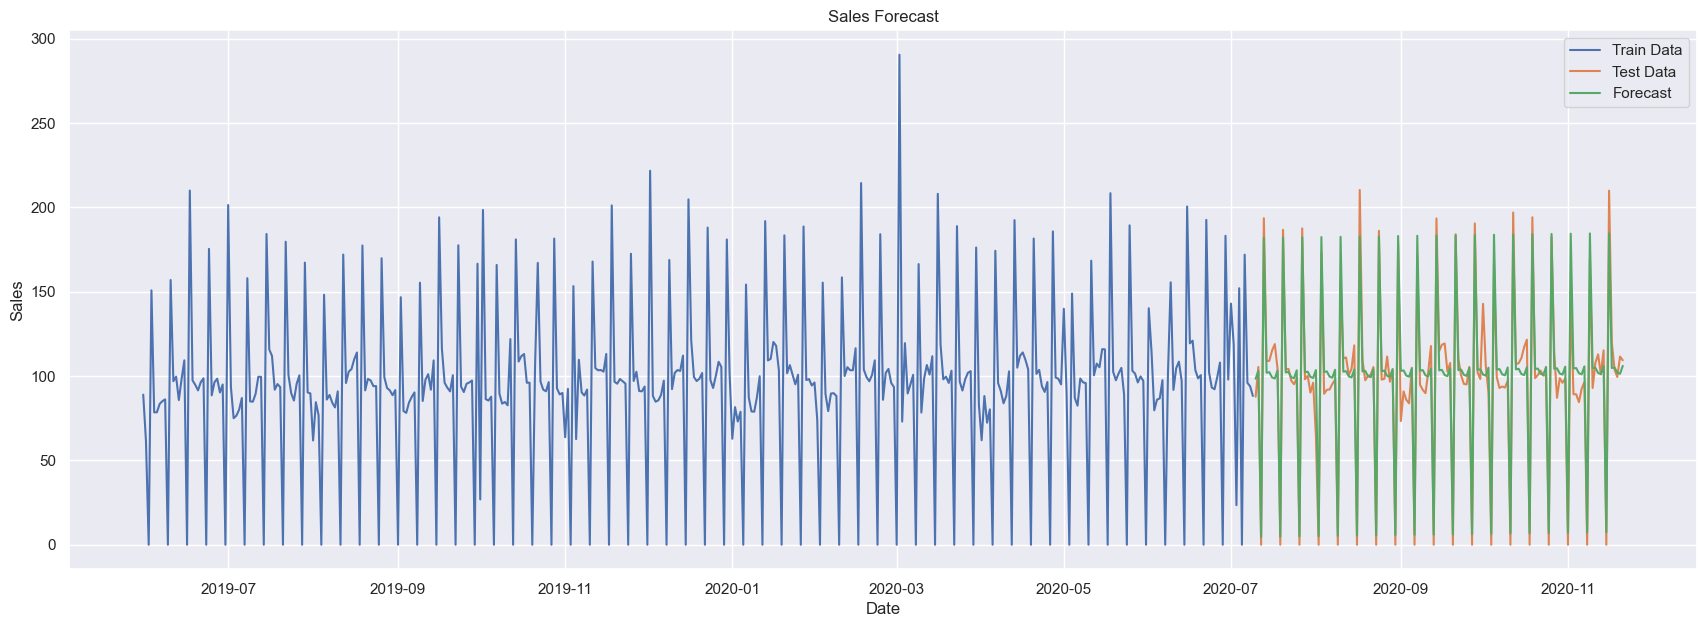

In [277]:
plt.figure(figsize=(21, 7))
plt.plot(y_train.index, y_train['val'], label='Train Data')
plt.plot(y_test.index, y_test['val'], label='Test Data')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend()
plt.show()

Лучший результат получился у ARIMA вместе с Deseasonalizer SMAPE: 0.0719

Сделаем прогноз по всем имеющимся данным на 9 последних дней ноября

In [279]:
df_train['val'] = df_train['val'].apply(lambda x: 0.000001 if x == 0 else x)
df_test['val'] = df_test['val'].apply(lambda x: 0.000001 if x == 0 else x)

In [281]:
df_train = df_train.asfreq('D')
df_test = df_test.asfreq('D')

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=7)),
    ("forecast", AutoARIMA(sp=7, suppress_warnings=True))
])

forecaster.fit(y=df_train)

fh_test = np.arange(len(df_test)) + 1
y_pred = forecaster.predict(fh=fh_test)

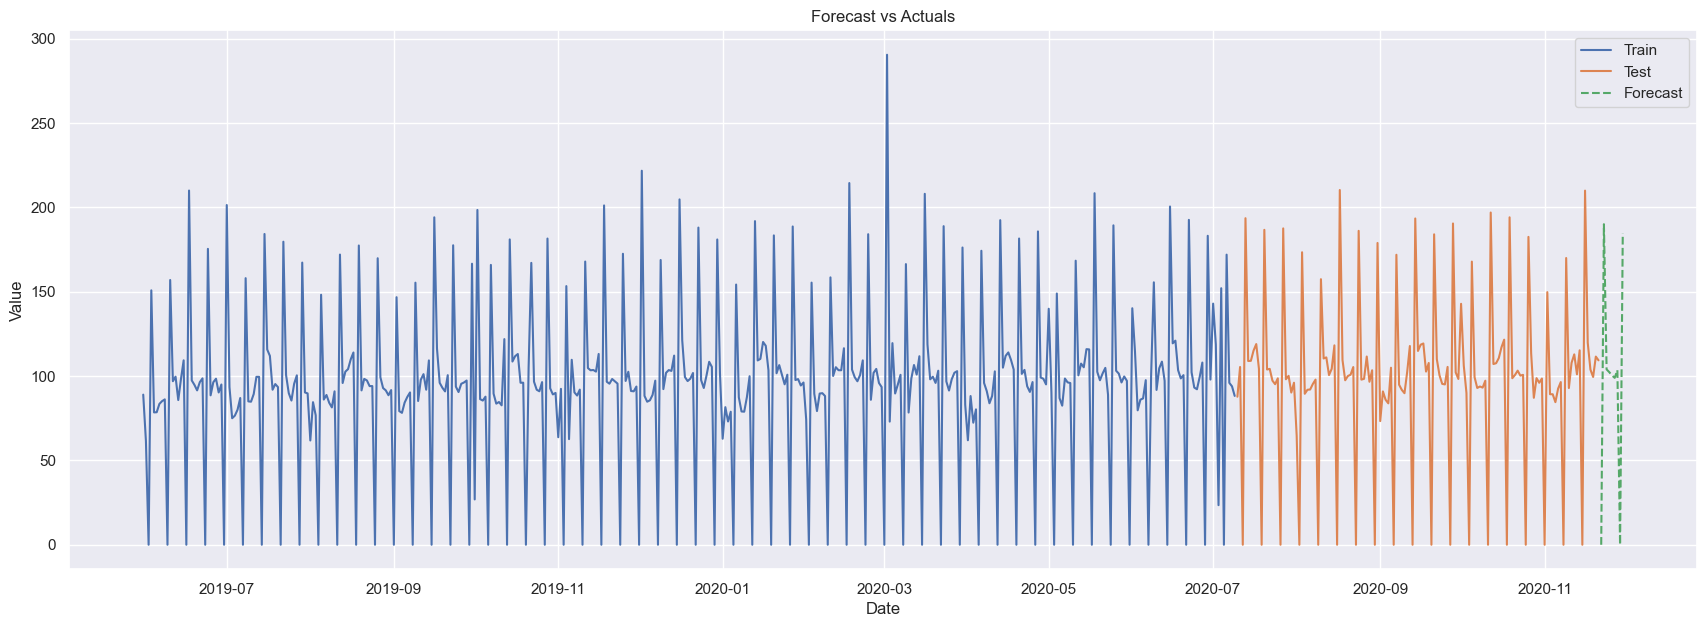

In [283]:
plt.figure(figsize=(21, 7))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_pred.index, y_pred, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast vs Actuals')
plt.legend()
plt.grid(True)
plt.show()

In [289]:
len_pred, sum_pred = len(y_pred['val']), y_pred['val'].sum()
len_pred, sum_pred

(9, 883.9157318175071)

In [292]:
len_train, sum_train = len((df_train[df_train.index >= '2020.11.01']['val'])), df_train[df_train.index >= '2020.11.01']['val'].sum()
len_train, sum_train

(21, 2055.749981)

In [296]:
print(f'Мой прогноз на ноябрь 2020 года - {round(sum_pred + sum_train, 2)} вместо прогноза 3188.91, составленного вначале года')

Мой прогноз на ноябрь 2020 года - 2939.67 вместо прогноза 3188.91, составленного вначале года
